# Non-linear classification

We have previously encountered the [binary logistic classification](classification-logistic-regression-model.ipynb) and [multi-class softmax classification](classification-multiclass.ipynb) models. Both models were decribed as linear in the sense that all decision boundaries, that is the regions where the most likely class switches from one class to another, are linear. This is a severe assumption that is not typically appropriate. In this section we will consider data where non-linear models are required. We will focus on non-linear binary logistic classification, but it will be straightforward to use the same approach for non-linear multi-class softmax classification.

In [11]:
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import HTML, set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

%config InlineBackend.figure_format = 'svg'

As a running example we will use the synthetic crescent dataset shown below. Even though the data is clearly easily separable, it is also clear that a linear logistic regression model is a poor choice here. This is because the data is _not linearly separable_, meaning that there is no straight line which could separate the red and blue classes. Thus a linear logistic regressor will necessarily misclassify several data.

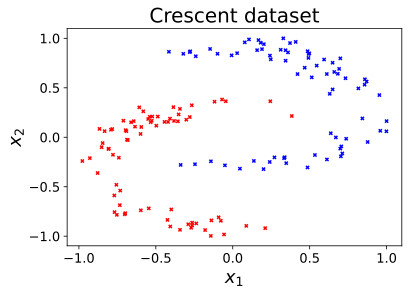

In [12]:
# Load inputs and labels
x = np.load('data/x_crescent.npy')
y = np.load('data/y_crescent.npy')

# Use 3/4 of data for training
num_train = (x.shape[0] * 3) // 4

x_train = x[:num_train]
y_train = y[:num_train]

x_test = x[num_train:]
y_test = y[num_train:]

class_0, class_1 = np.where(y_train == 0), np.where(y_train == 1)

# Plot data
plt.scatter(x_train[class_0, 0], x_train[class_0, 1], color='blue', marker='x', s=10)
plt.scatter(x_train[class_1, 0], x_train[class_1, 1], color='red', marker='x', s=10)

plt.xticks(np.linspace(-1., 1., 5), fontsize=13)
plt.yticks(np.linspace(-1., 1., 5), fontsize=13)

plt.title("Crescent dataset", fontsize=20)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18)
plt.show()

### Non-linear classification through basis functions

This section is based in one key insight that we [previously used to generalise linear regression to non-linear regression](../regression/regression-nonlinear.ipynb). The linear logistic regression model computes the activations which are a **linear function of the inputs** 

$$\begin{align}
a_n = \mathbf{w}^\top \mathbf{x}_n = \sum_{d=1}^D w_d x_{n,d}.
\end{align}$$

and then applies a **point-wise non-linearity**

$$\begin{align}
p(y_n = 1 | \mathbf{x}_n, \mathbf{w}) = \sigma(a_n)  = \frac{1}{1 + \text{exp}(-a_n)} .
\end{align}$$

We can therefore change the first stage by viewing the underlying non-linear function - i.e. the activations - as a linear combination of **non-linear basis functions**,  

$$\begin{align}
a_n = w_0 + w_1 \phi_{1}(\mathbf{x}_n) + w_2 \phi_{2}(\mathbf{x}_n) + ... w_D \phi_{D}(\mathbf{x}_n) = \mathbf{w}^\top \boldsymbol{\Phi}(\mathbf{x}_n)
\end{align}$$

Mathematically the change is very simple: we replace each datapoint $\mathbf{x}_n$ with its representation in terms of non-linear basis functions $\boldsymbol{\Phi}(\mathbf{x}_n)$. The non-linear model can then be compactly written,

$$\begin{align}
p(y_n = 1 | \mathbf{x}_n, \mathbf{w}) = \sigma(\mathbf{w}^\top \boldsymbol{\Phi}(\mathbf{x}_n)).
\end{align}$$

Maximum-likelihood estimation proceeds as before, with each datapoint replaced by $\boldsymbol{\Phi}(\mathbf{x}_n)$. The algorithmic implementation of the non-linear model is __exactly the same as for the linear case__. Rather than passing the inputs $\mathbf{x}_{1:N}$ we pass non-linear basis function representation instead,

$$\begin{align}
\boldsymbol{\Phi} =  \begin{pmatrix}
1 & \phi_1(x_1) & \cdots & \phi_D(x_1)\\\
1 & \phi_1(x_2) & \cdots & \phi_D(x_2)\\\
\vdots & \vdots & \ddots & \vdots \\\
1 & \phi_1(x_N) & \cdots & \phi_D(x_N)\\\
\end{pmatrix}.
\end{align}$$

Let's apply this method to the crescent dataset. First we define the logistic and gradient ascent functions, [as used previously](classification-logistic-regression-ML-fitting.ipynb). 

In [13]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def gradient_ascent(x, y, w0, num_steps, stepsize):
    
    # Add ones to the inputs as usual, absorbing the bias term
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1)
    
    # Copy weights (to prevent changing init_weights as a side-effect
    w = w0.copy() 
    
    # Arrays for storing weights and log-liklihoods at each step
    w_history = []
    log_liks = []
    
    for n in range(num_steps):
        
        # Record current log-lik and current weights
        log_lik = np.sum(y * np.log(sigmoid(x.dot(w))) + (1 - y) * np.log(1 - sigmoid(x.dot(w))))
        log_liks.append(log_lik)
        w_history.append(w.copy())
    
        # Compute σ(x^T x)
        sigma = sigmoid(x.dot(w))
        
        # Calculate gradient of log-likelihood w.r.t. w
        dL_dw = np.mean((y - sigma)*x.T, axis = 1) 
        
        # Update weights and repeat
        w += stepsize * dL_dw 
    
    return np.array(w_history), np.array(log_liks)

Second, we have to select appropriate basis functions. Here we use isotropic Gaussian basis functions

$$\begin{align}
\phi_{d}(\mathbf{x}) = \exp\left(-\frac{1}{2 l^2} | \mathbf{x} - \mu_{d}|^2\right).
\end{align}$$

These are also called **radial basis functions**. The means $\mu_d$ are arranged in a 7 x 7 grid across the input space and have a length-scale equal to 0.3. These basis functions are shown on the right subplot below. On the right hand side you can see the log-likelihood plotted as a function of the number of iterations of gradient ascent.

In [14]:
# Lengthscale of nonlinear basis functions
lengthscale = 0.3

# Use a 7 by 7 grid of basis functions
num_x, num_y = 7, 7

mu1 = np.linspace(-1.1, 1.1, num_x)
mu2 = np.linspace(-1.1, 1.1, num_y)

# Points at which to place basis functions
rbf_grid = np.stack(np.meshgrid(mu1, mu2), axis=2)
rbf_grid = np.stack([rbf_grid] * x_train.shape[0], axis = 0)

# Training inputs
points = np.stack([x_train] * num_x * num_y, axis = 1)
points = points.reshape((x_train.shape[0], num_x, num_y, 2))

# Basis function values at training points
phi = np.exp(-np.sum((rbf_grid - points) ** 2, axis = -1) / (2 * lengthscale ** 2))
phi = phi.reshape((x_train.shape[0], -1))

# Optimise weights
w_history, log_liks = gradient_ascent(phi, y_train, np.zeros(shape = (num_x*num_y + 1,)), 500, 1)

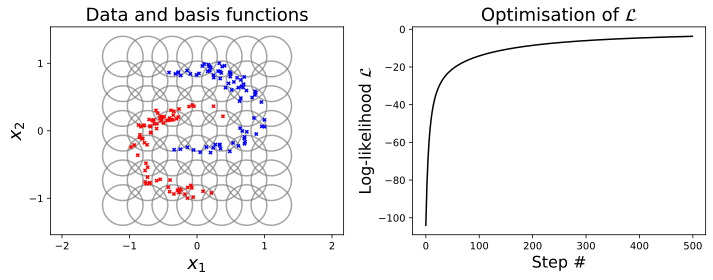

In [15]:
# Figure to plot on
fig = plt.figure(figsize=(10, 4), dpi= 80)

# First subplot showing data and basis functions
plt.subplot(1, 2, 1)

# Circles for representing basis functions
theta = np.linspace(0, 2. * np.pi, 50)                  
x_circ = lengthscale * np.cos(theta)    
y_circ = lengthscale * np.sin(theta)                        
      
# Plot one circle per basis function
for a in range(num_x):
    for b in range(num_y):
        
        xs = mu1[a] + x_circ
        ys = mu2[b] + y_circ
        
        plt.plot(xs, ys, color="gray", alpha=0.7, zorder=1)
                    
plt.scatter(x_train[class_0, 0], x_train[class_0, 1], color="blue", marker="x", s=10, zorder=2)
plt.scatter(x_train[class_1, 0], x_train[class_1, 1], color="red", marker="x", s=10, zorder=2)

plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18)

plt.xticks(np.linspace(-2., 2., 5))
plt.yticks(np.linspace(-2., 2., 5))

plt.xlim([-2., 2.])
plt.ylim([-2., 2.])

plt.title("Data and basis functions", fontsize=18)
plt.axis("equal")

# Second plot showing data and basis functions
plt.subplot(1, 2, 2)
plt.plot(log_liks, color="k")

plt.title("Optimisation of $\mathcal{L}$", fontsize=18)
plt.xlabel("Step #", fontsize=16)
plt.ylabel("Log-likelihood $\mathcal{L}$", fontsize=16)

fig.tight_layout()
plt.show()

Now lets try and visualise the predictions of the trained model as probability contours in the input space $\mathbf{x}$. In the  figure below input points that have a strong red colour correspond to confident predictions of class 1, points that are  a strong blue colour correspond to confident predictions of class 0, and points that are not strongly coloured are close to 50:50. The probability contours are clearly non-linear and the model appears to be making reasonable predictions.

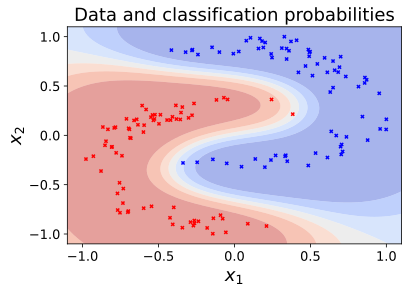

In [16]:
# Grid to plot classification probabilities at
plot_grid = np.meshgrid(np.linspace(-1.1, 1.1, 100),
                        np.linspace(-1.1, 1.1, 100))
plot_grid = np.stack(plot_grid, axis=2).reshape((-1, 2))
plot_grid = np.stack([plot_grid] * num_x * num_y, axis = 1).reshape((plot_grid.shape[0], num_x, num_y, 2))

# RBF locations
rbf_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, num_x),
                                np.linspace(-1.1, 1.1, num_y)),
                    axis = 2)
rbf_grid = np.stack([rbf_grid] * plot_grid.shape[0], axis=0)

# Basis function values at prediction points
phi = np.exp(-np.sum((rbf_grid - plot_grid)**2, axis = -1) / (2 * lengthscale ** 2))
phi = phi.reshape((plot_grid.shape[0], -1))
phi = np.append(np.ones(shape=(phi.shape[0], 1)), phi, axis = -1)

# Prediction probablities using weights returned by optimisation
pred = sigmoid(phi.dot(w_history[-1]))
pred = pred.reshape(100, 100)

# Plot classification probabilities
plt.contourf(np.linspace(-1.1, 1.1, 100),
             np.linspace(-1.1, 1.1, 100),
             pred,
             cmap="coolwarm",
             alpha=0.5,
             origin="lower")

plt.scatter(x_train[class_0, 0],
            x_train[class_0, 1],
            color="blue",
            marker="x",
            s=10)

plt.scatter(x_train[class_1, 0],
            x_train[class_1, 1],
            color="red",
            marker="x",
            s=10)

plt.title("Data and classification probabilities", fontsize=18)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18)

plt.xticks(np.linspace(-1., 1., 5), fontsize=13)
plt.yticks(np.linspace(-1., 1., 5), fontsize=13)

plt.show()

Finally, lets see how the model performs on the test set.

In [17]:
def test_accuracy(x_test, y_test, w):
    
    # Add ones to x's to absorb the bias term
    x_test = np.append(np.ones(shape=(x_test.shape[0], 1)), x_test, axis = 1)
    pred = sigmoid(x_test.dot(w))
    
    return 1 - abs((pred.round() - y_test)).mean()

# Locations of RBF basis functions
rbf_grid = np.stack(np.meshgrid(np.linspace(-1.1, 1.1, num_x),
                                np.linspace(-1.1, 1.1, num_y)),
                    axis = 2)
rbf_grid = np.stack([rbf_grid] * x_test.shape[0], axis=0)

# Testing inputs
points = np.stack([x_test] * num_x * num_y, axis=1)
points = points.reshape((x_test.shape[0], num_x, num_y, 2))

# Basis function values at testing points
phi = np.exp(-np.sum((rbf_grid - points)**2, axis=-1) / (2 * lengthscale ** 2))
phi = phi.reshape((x_test.shape[0], -1))

test_accuracy = 100 * test_accuracy(phi, y_test, w_history[-1])
print(f"Classification accuracy for non-linear dataset = {test_accuracy}%")

Classification accuracy for non-linear dataset = 100.0%


### Summary

Logistic and softmax classification can be turned into non-linear classifiers simply by changing the representation of the input. Instead of passing the inputs $\mathbf{x}_n$ directly to the algorithm, we can pass non-linear functions of the input $\boldsymbol{\Phi}(\mathbf{x}_n)$. These functions are called basis functions or features.

The basis functions need careful design (e.g. see question 1 below). Moreover, the naive method of tiling the space, as used in the examples above, does not scale to high dimensional input spaces where an exponential number of functions would be required. However, strategies such as centering radial basis functions at a randomly selected subset of the datapoints can sidestep the curse of dimensionality and work reasonably well.


In the next [section](classification-overfitting.ipynb) we will look at overfitting phenomena in these classification models.

### Questions

<ol>
<li> <b>Effect of the number and length-scale of the basis functions:</b> Experiment with the code above to investigate the effect of using large and short length-scales in the basis functions, and small or large numbers of basis functions. See how these choices alter the final log-likelihood and the predictive probability contours.<br><br>

<details class="graydrop">
<summary>Answer</summary>
<div>
    
Using very narrow radial basis functions with short length-scales results in probability contours that are less smooth and requires more basis functions for sensible predictions. Using broader radial basis function results in smoother contours and fewer basis functions are required, but the predictions might be overly simplistic.<br><br>

One useful rule of thumb for setting the width of radial basis functions is called the **median trick**. The median trick begins by computing the pairwise distances between the datapoints' inputs. It then sets the length-scale to be the median distance value.

</div>
</details>
<br>
</li>
</ol>


<ol start="2">
<li> <b>Overfitting:</b> Can you make the model above overfit? Change the length-scale and number of the basis functions, and increase the number of iterations of gradient ascent.<br> <br>

<details class="graydrop">
<summary>Answer</summary>
<div>
When large numbers of narrow basis functions are used (e.g. D = 40 x 40, l = 0.02) and many iterations of gradient ascent applied (e.g. tens of thousands) the model starts to overfit. Such a simulation can take a long time to run, but the log-likelihood asymptotes close to 0, whilst the test set accuracy is around 90% which is less than it was for the original setting (D = 7 x 7, l = 0.3, 500 iterations scores 100% accuracy on the test set). <br><br>

This is a classic example of overfitting: the model complexity grows with the number of basis functions and as the length-scale gets shorter. At somepoint the model can perfectly capture the training data, but makes poor predictions on the test data. One approach to preventing overfitting is to regularise the weights. Another, arguably less principled, approach is to use early stopping: that is, terminate gradient ascent before the model starts to overfit. 
</div>
</details>
<br>
</li>
</ol>